In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

In [21]:
df = pd.read_csv("test.csv")
df2 = pd.read_csv("test2.csv")
df = pd.concat([df, df2])
    
# Parse JSON columns
df["lidar"] = df["lidar"].apply(json.loads)
df["imu_acc"] = df["imu_acc"].apply(json.loads)
df["imu_angle"] = df["imu_angle"].apply(json.loads)
df.head()

,ts,lidar,imu_acc,imu_angle,speed,angle
0,0.025178,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.009927213191986084, -9.82823371887207, -0....","[-0.013989591039717197, 0.0054701329208910465,...",0.0,0.0
1,0.050355,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.020355334505438805, -9.81666374206543, -0....","[0.00023889890871942043, 0.004294745158404112,...",0.0,0.0
2,0.078101,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02385137416422367, -9.817397117614746, -0....","[0.0002890098839998245, -0.00936887413263321, ...",0.0,0.0
3,0.105964,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.009922361001372337, -9.813043594360352, -0...","[-0.007079764269292355, -0.003466258058324456,...",0.0,0.0
4,0.132942,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.008763235993683338, -9.797097206115723, -0...","[-0.0011799503117799759, 0.0026670917868614197...",0.0,0.0


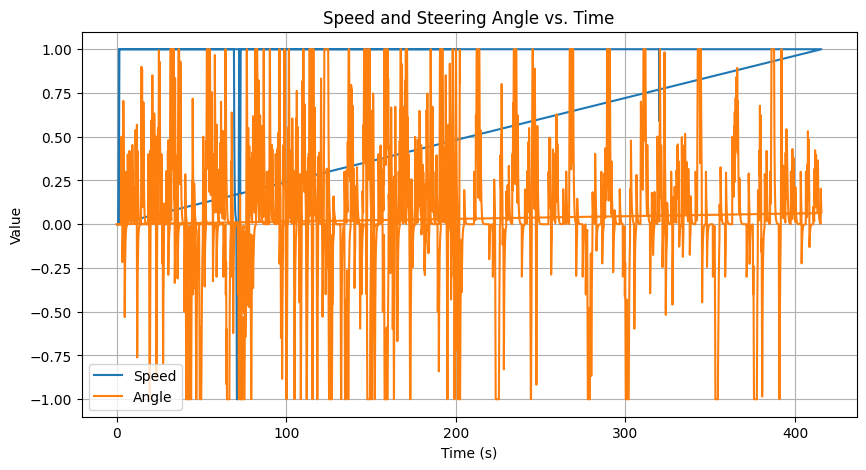

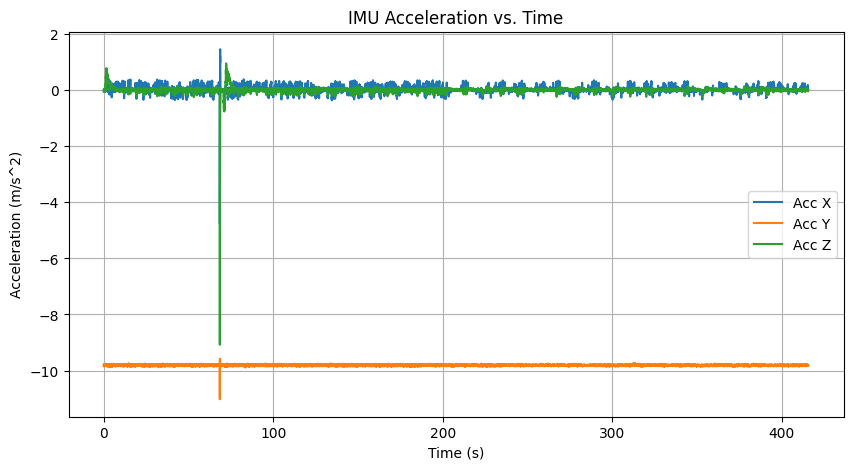

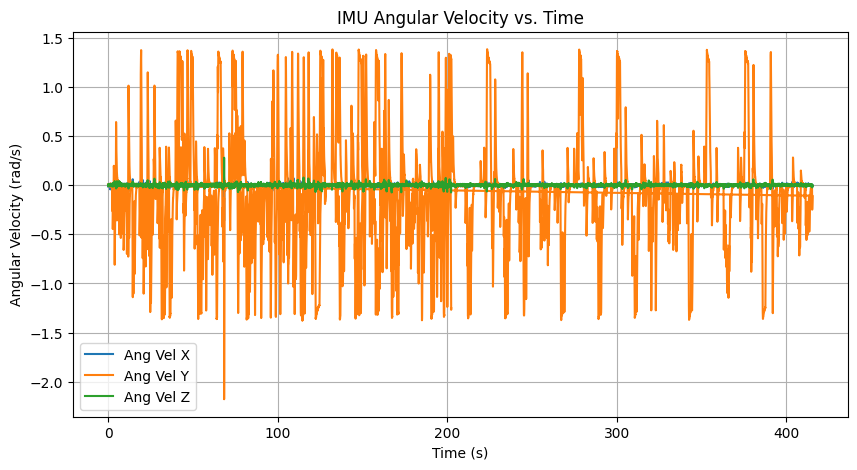

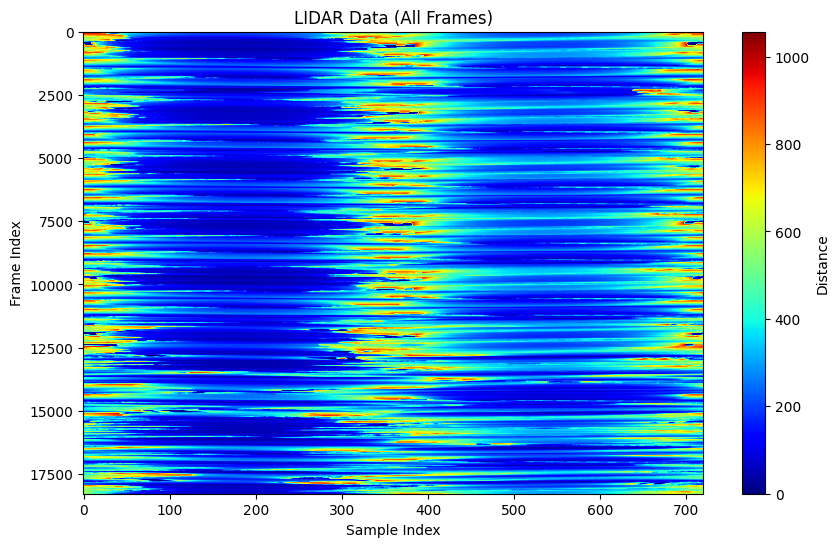

In [22]:
def sanity_plot(df):
    # ----------------------------------
    # Optionally, still plot Speed/Angle
    # ----------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(df["ts"], df["speed"], label="Speed")
    plt.plot(df["ts"], df["angle"], label="Angle")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.title("Speed and Steering Angle vs. Time")
    plt.legend()
    plt.grid(True)

    # ----------------------------------
    # Optionally, still plot IMU data
    # ----------------------------------
    # IMU Acceleration
    imu_acc_matrix = np.array(df["imu_acc"].tolist())  # shape: (n_frames, 3)
    plt.figure(figsize=(10, 5))
    plt.plot(df["ts"], imu_acc_matrix[:, 0], label="Acc X")
    plt.plot(df["ts"], imu_acc_matrix[:, 1], label="Acc Y")
    plt.plot(df["ts"], imu_acc_matrix[:, 2], label="Acc Z")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("IMU Acceleration vs. Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # IMU Angular Velocity
    imu_ang_matrix = np.array(df["imu_angle"].tolist())  # shape: (n_frames, 3)
    plt.figure(figsize=(10, 5))
    plt.plot(df["ts"], imu_ang_matrix[:, 0], label="Ang Vel X")
    plt.plot(df["ts"], imu_ang_matrix[:, 1], label="Ang Vel Y")
    plt.plot(df["ts"], imu_ang_matrix[:, 2], label="Ang Vel Z")
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (rad/s)")
    plt.title("IMU Angular Velocity vs. Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------------------------------------------
    #  Visualize ALL LIDAR frames as a 2D "image"
    # ---------------------------------------------------
    # Convert list of lists into a 2D array:
    # shape will be (#_of_frames, #_of_lidar_samples)
    lidar_matrix = np.array(df["lidar"].tolist())

    # Plot as an image with each row = 1 frame, each column = 1 sample
    plt.figure(figsize=(10, 6))
    plt.imshow(lidar_matrix, cmap="jet", aspect="auto")
    plt.colorbar(label="Distance")
    plt.xlabel("Sample Index")
    plt.ylabel("Frame Index")
    plt.title("LIDAR Data (All Frames)")
    plt.show()

sanity_plot(df)

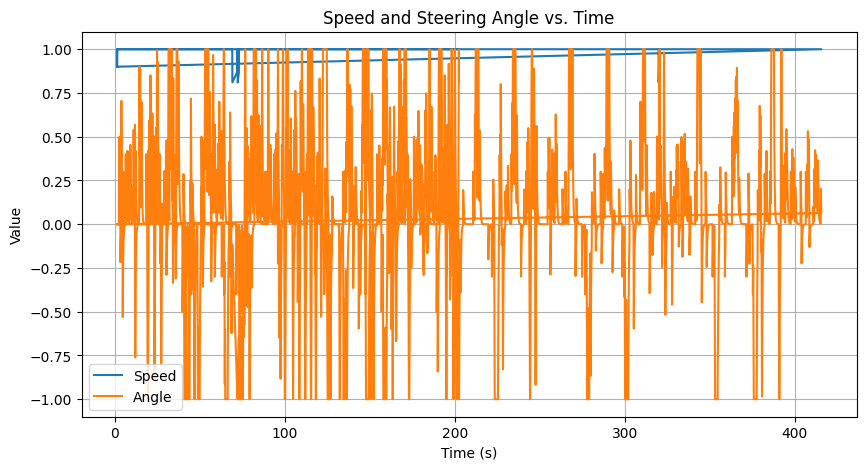

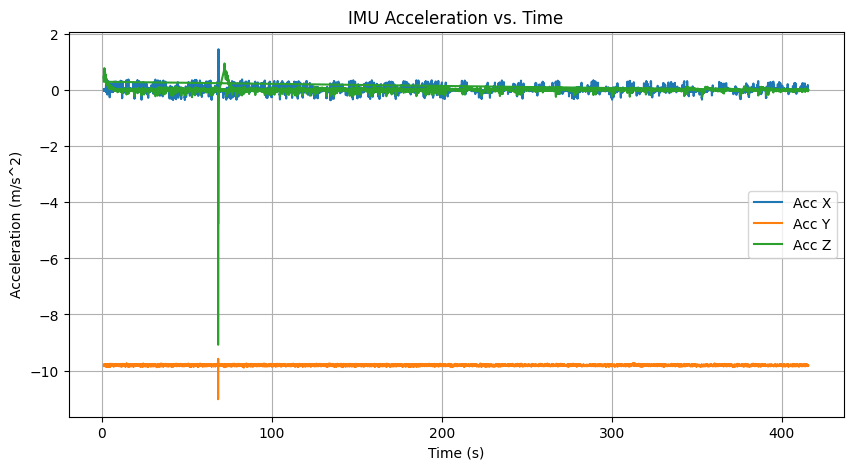

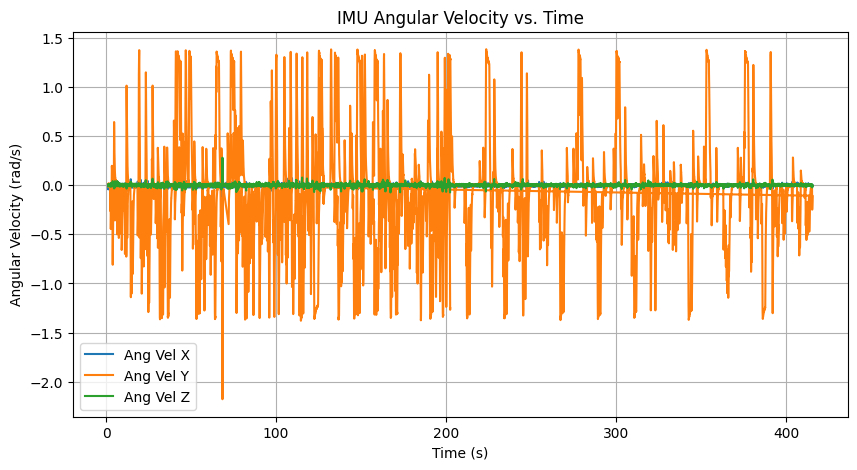

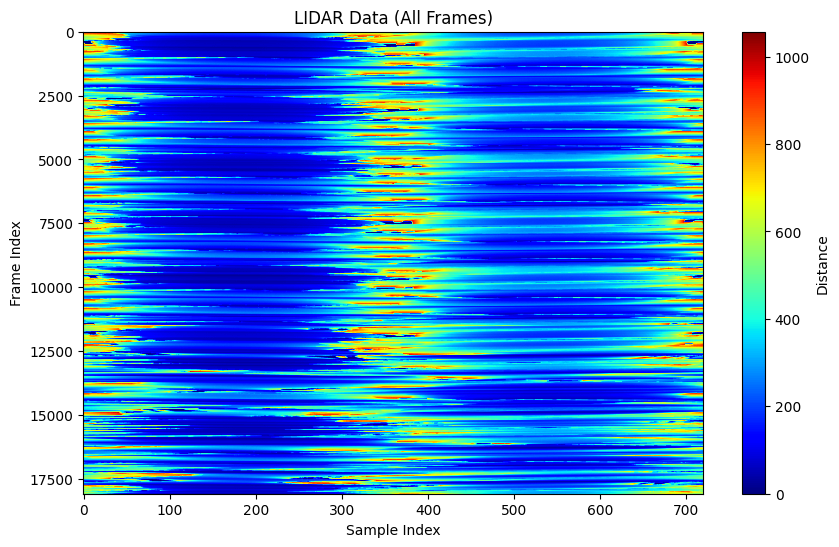

In [23]:
# eliminate all rows within N rows where speed is 0 or less
N = 10
df["speed"].rolling(N).mean().dropna()
df = df[df["speed"] > 0.8]
# reset index
df = df.reset_index(drop=True)
# ---------------------------------------------------
sanity_plot(df)

mean: 0.05242824000543232, std: 0.3712767646400387


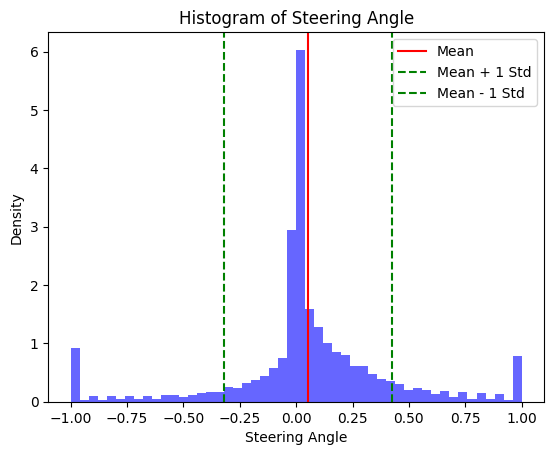

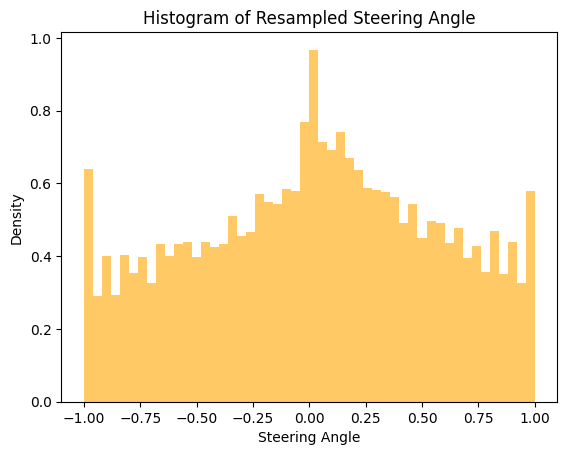

original df: 18082, resampled df: 18082


In [24]:
# determine ROI for angle
# 1. assume gaussian distribution, find mean and std
mean = df["angle"].mean()
std = df["angle"].std()
print(f"mean: {mean}, std: {std}")

# 2. plot histogram of angle
plt.hist(df["angle"], bins=50, density=True, alpha=0.6, color="b")
plt.xlabel("Steering Angle")
plt.ylabel("Density")
plt.title("Histogram of Steering Angle")
plt.axvline(mean, color="red", label="Mean")
plt.axvline(mean + std, color="green", linestyle="dashed", label="Mean + 1 Std")
plt.axvline(mean - std, color="green", linestyle="dashed", label="Mean - 1 Std")
plt.legend()
plt.show()

# 3. Determine sampling coefficients to get a more uniform distribution

# Compute histogram of the angles
hist, bin_edges = np.histogram(df["angle"], bins=50, density=False)

# Compute the inverse probability for each bin
hist = hist + 1  # Avoid division by zero
weights = (1.0 / hist)**0.8

# Assign each sample a weight based on the bin it falls into
bin_indices = np.digitize(df["angle"], bin_edges[:-1])  # Find bin for each sample
sampling_weights = np.array([weights[idx - 1] for idx in bin_indices])  # Get corresponding weights

# Normalize weights to sum to 1
sampling_weights /= sampling_weights.sum()

# Resample the dataset using the computed weights
resampled_df = df.sample(n=len(df), replace=True, weights=sampling_weights, random_state=42)

# Plot the new distribution
plt.hist(resampled_df["angle"], bins=50, density=True, alpha=0.6, color="orange")
plt.xlabel("Steering Angle")
plt.ylabel("Density")
plt.title("Histogram of Resampled Steering Angle")
plt.show()

#  comparison of total samples before and after
print(f"original df: {len(df)}, resampled df: {len(resampled_df)}")


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import regression tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df_ = resampled_df
# ---------------------------------------------------
# 1. Prepare the data
# ---------------------------------------------------
# Define the features and target variable -> features: lidar + imu acc + imu angle, target: angle 
lidar_features = pd.DataFrame(df_["lidar"].tolist())
# imu_acc_features = pd.DataFrame(df_["imu_acc"].tolist())
# imu_angle_features = pd.DataFrame(df_["imu_angle"].tolist())
# print(f"lidar_features: {lidar_features.shape}, imu_acc_features: {imu_acc_features.shape}, imu_angle_features: {imu_angle_features.shape}")
# features = pd.concat([lidar_features, imu_acc_features, imu_angle_features], axis=1)
features = lidar_features
print(f"features: {features.shape}")
print(f"features[0]: {features[0].shape}")
target = df_["angle"]

# standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# ---------------------------------------------------
# 2. Train the model
# ---------------------------------------------------
# Initialize the model
RandomForest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)
GB_model = GradientBoostingRegressor(n_estimators=100, random_state=42, verbose=1)
# Train the model
print("Training the Random Forest model...")
RandomForest_model.fit(X_train, y_train)
print("Training the Gradient Boosting model...")
GB_model.fit(X_train, y_train)
# Make predictions
print("Making predictions...")
RF_y_pred = RandomForest_model.predict(X_test)
GB_y_pred = GB_model.predict(X_test)
# Evaluate the model
RF_mae = mean_absolute_error(y_test, RF_y_pred)
RF_mse = mean_squared_error(y_test, RF_y_pred)
RF_r2 = r2_score(y_test, RF_y_pred)
GB_mae = mean_absolute_error(y_test, GB_y_pred)
GB_mse = mean_squared_error(y_test, GB_y_pred)
GB_r2 = r2_score(y_test, GB_y_pred)
# Print the evaluation metrics
print("Random Forest Regressor:")
print("MAE:", RF_mae)
print("MSE:", RF_mse)
print("R2:", RF_r2)
print("Gradient Boosting Regressor:")
print("MAE:", GB_mae)
print("MSE:", GB_mse)
print("R2:", GB_r2)
# ---------------------------------------------------

features: (18082, 720)
features[0]: (18082,)
Training the Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


Training the Gradient Boosting model...
      Iter       Train Loss   Remaining Time 
         1           0.2597            2.62m
         2           0.2355            2.79m
         3           0.2164            2.68m
         4           0.2000            2.62m
         5           0.1845            2.56m
         6           0.1711            2.51m
         7           0.1610            2.52m
         8           0.1504            2.50m
         9           0.1423            2.47m
        10           0.1334            2.43m
        20           0.0906            2.10m
        30           0.0715            1.83m
        40           0.0623            1.57m
        50           0.0561            1.30m
        60           0.0519            1.04m
        70           0.0480           46.76s
        80           0.0454           31.09s
        90           0.0429           15.55s
       100           0.0409            0.00s
Making predictions...
Random Forest Regressor:
MAE: 0.02484

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [26]:
# save the model
import _pickle as cPickle

with open('RandomForest.pkl', 'wb') as f:
    cPickle.dump(RandomForest_model, f)

with open('GB.pkl', 'wb') as f:
    cPickle.dump(GB_model, f)

# save the scaler
with open('scaler.pkl', 'wb') as f:
    cPickle.dump(scaler, f)


In [27]:
# load and evaluate the model to make sure it works
with open('RandomForest.pkl', 'rb') as f:
    RandomForest_model = cPickle.load(f)
    RandomForest_model.verbose = 0
    RandomForest_model.n_jobs = 1

with open('scaler.pkl', 'rb') as f:
    scaler = cPickle.load(f)
with open('GB.pkl', 'rb') as f:
    GB_model = cPickle.load(f)
    GB_model.verbose = 0

# make sure the model works
print("Testing the saved model...")
#  use the scaler to transform the features
X_test = scaler.transform(features)
# Make predictions
RF_y_pred = RandomForest_model.predict(X_test)
GB_y_pred = GB_model.predict(X_test)
# Evaluate the model
RF_mae = mean_absolute_error(target, RF_y_pred)
RF_mse = mean_squared_error(target, RF_y_pred)
RF_r2 = r2_score(target, RF_y_pred)
GB_mae = mean_absolute_error(target, GB_y_pred)
GB_mse = mean_squared_error(target, GB_y_pred)
GB_r2 = r2_score(target, GB_y_pred)
# Print the evaluation metrics
print("Random Forest Regressor:")
print("MAE:", RF_mae)
print("MSE:", RF_mse)
print("R2:", RF_r2)
print("Gradient Boosting Regressor:")
print("MAE:", GB_mae)
print("MSE:", GB_mse)
print("R2:", GB_r2)


Testing the saved model...
Random Forest Regressor:
MAE: 0.7219775429326419
MSE: 0.7353651383894872
R2: -1.5631456899570306
Gradient Boosting Regressor:
MAE: 0.6648445281349076
MSE: 0.6305517712761058
R2: -1.1978143516304431
